In [84]:
using JuMP, Ipopt
using Plots
using NPZ

In [85]:
hull_points = npzread("Data/convex_hull_points.npy")

20×2 Array{Float64,2}:
      3.29135e5  4.40856e6
 328903.0        4.40883e6
 328897.0        4.40884e6
 328896.0        4.40884e6
 328848.0        4.40883e6
 328846.0        4.40883e6
      3.28798e5  4.40883e6
      3.28796e5  4.40883e6
      3.28792e5  4.40883e6
      3.2803e5   4.40779e6
      3.27809e5  4.40747e6
      3.27806e5  4.40746e6
      3.27806e5  4.40745e6
      3.27807e5  4.40745e6
      3.27807e5  4.40745e6
 327809.0        4.40743e6
      3.2781e5   4.40742e6
 328255.0        4.40739e6
      3.2826e5   4.40739e6
      3.28457e5  4.40765e6

In [86]:
x = hull_points[:,1]
y = hull_points[:,2]
md2 = maximum((x.-x').^2 .+ (y.-y').^2)

3.1922212159993006e6

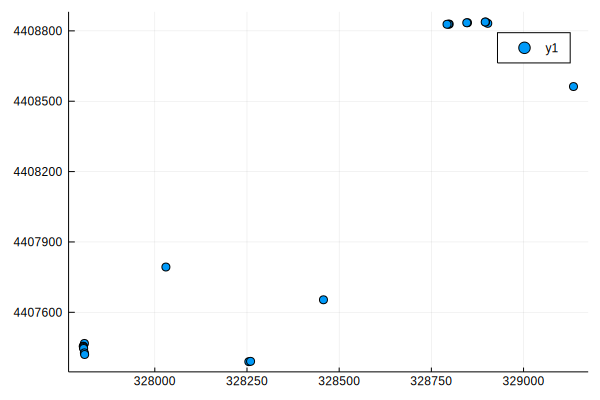

In [87]:
scatter(x,y)

In [88]:
model = Model(with_optimizer(Ipopt.Optimizer))

A JuMP Model
Feasibility problem with:
Variables: 0
Model mode: AUTOMATIC
CachingOptimizer state: EMPTY_OPTIMIZER
Solver name: Ipopt

In [89]:
@variable(model, x1[1:2])
@variable(model, x2[1:2])
@variable(model, x3[1:2])
@variable(model, x4[1:2])
set_start_value.(x1, [minimum(x), minimum(y)])
set_start_value.(x2, [minimum(x), maximum(y)])
set_start_value.(x3, [maximum(x), maximum(y)])
set_start_value.(x4, [maximum(x), minimum(y)])

2-element Array{Nothing,1}:
 nothing
 nothing

In [90]:
#90 degree corners
@constraint(model, (x2-x1)' * (x3-x2) == 0)
@constraint(model, (x3-x2)' * (x4-x3) == 0)
@constraint(model, (x4-x3)' * (x1-x4) == 0)
@constraint(model, (x1-x4)' * (x2-x1) == 0)
# diagonals meet at 90 degrees (for square)
# @constraint(model, (x1-x3)' * (x2-x4) == 0)
# side length ratio (for rectangle)
ratio = 4
@constraint(model, ratio^2*(x1-x2)' * (x1-x2) - (x3-x2)' * (x3-x2) == 0)
@constraint(model, (x1-x3)' * (x1-x3) >= md2*1.05^2) #5% padding for interpolation

x1[1]² - 2 x3[1]*x1[1] + x3[1]² + x1[2]² - 2 x3[2]*x1[2] + x3[2]² ≥ 3.519423890639229e6

In [91]:
for (xp, yp) in zip(x,y)
    p = [xp, yp]
    @constraint(model,  (x2[1]-x1[1])' * (p[2]-x1[2]) - (x2[2]-x1[2])' * (p[1]-x1[1])  <= 0)
    @constraint(model,  (x3[1]-x2[1])' * (p[2]-x2[2]) - (x3[2]-x2[2])' * (p[1]-x2[1])  <= 0)
    @constraint(model,  (x4[1]-x3[1])' * (p[2]-x3[2]) - (x4[2]-x3[2])' * (p[1]-x3[1])  <= 0)
    @constraint(model,  (x1[1]-x4[1])' * (p[2]-x4[2]) - (x1[2]-x4[2])' * (p[1]-x4[1])  <= 0)
end

In [92]:
@objective(model, Min, (x3-x1)' * (x3-x1))

x3[1]² - 2 x1[1]*x3[1] + x1[1]² + x3[2]² - 2 x1[2]*x3[2] + x1[2]²

In [93]:
optimize!(model)

This is Ipopt version 3.12.10, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:       70
Number of nonzeros in inequality constraint Jacobian.:      808
Number of nonzeros in Lagrangian Hessian.............:      294

Total number of variables............................:        8
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        5
Total number of inequality constraints...............:       81
        inequality constraints with only lower bounds:        1
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:       80

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

In [94]:
termination_status(model)

NUMERICAL_ERROR::TerminationStatusCode = 20

In [95]:
objective_value(model)

3.630265328125e6

In [96]:
corners = [value.(x1) value.(x2) value.(x3) value.(x4)]
xc = corners[1,:]
yc = corners[2,:]
xcp = [xc; xc[1]]
ycp = [yc; yc[1]]

5-element Array{Float64,1}:
 4.407154078146025e6
 4.407424790693059e6
 4.408922841349106e6
 4.408652128800717e6
 4.407154078146025e6

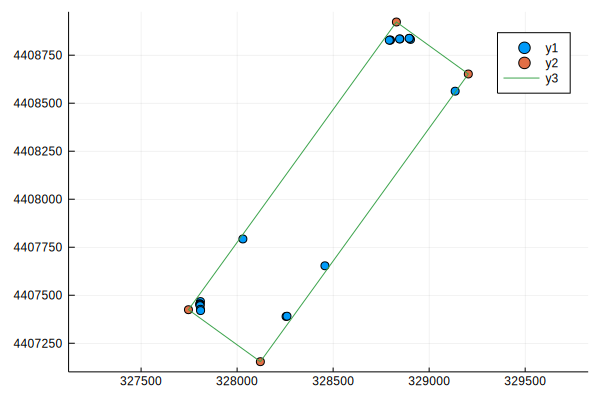

In [97]:
scatter(x,y)
scatter!(corners[1,:], corners[2,:])
plot!(xcp,ycp, aspect_ratio=:equal)

In [98]:
corners

2×4 Array{Float64,2}:
 3.28121e5  3.27747e5  3.28829e5  329204.0      
 4.40715e6  4.40742e6  4.40892e6       4.40865e6

In [99]:
sqrt((corners[:,1].-corners[:,2])' * (corners[:,1].-corners[:,2]) / ((corners[:,3].-corners[:,2])' * (corners[:,3].-corners[:,2])))

0.24999999902472267

In [100]:
(corners[:,1].-corners[:,4])' * (corners[:,1].-corners[:,4])

3.4167203061066945e6

In [101]:
npzwrite("Data/rectangle_corners.npy", corners)